In [36]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from datetime import datetime



## 추측할 수 있는 것  
1. 어떤 방법으로 구해보아도 재방문 비율이 높지 않다.  
2. 단순 데이터의 문제일수도 있겠지만 플랫폼, 여행이라는 특성의 영향도 있다고 보인다.    
3. 매 분기, 매 년 여행을 다니는 사람의 수가 이론상 많을 수가 없다고 생각한다.  
이 이유와 약 6개월정도의 데이터임을 감안하면 재방문율이 낮게 나오는것은 자연스러운것으로 보인다.  
4. 이용자수가 급등한 것이 세션 총 이용시간이 줄어서, 해당 세션에서 진행하는 시간이 줄어서 라고 가설을 세워보고 싶다.  
왜냐하면 세션에서 소비하는 시간이 줄어드는것을 그만큼 예약이 쉬워졌다. UI/UX가 개선되었다고 볼수있을 것 같기 때문이다.  
5. 실제로 신규 이용자 수와 세션에서 소비하는 시간의 상관계수를 구해보았을 때 -0.2 정도로 강하지는 않지만 어느정도 역상관관계를 가지는 것을 확인할 수 있었다.  


In [2]:
st_df = pd.read_csv("user_session_merged.csv")

/tmp/ipykernel_714/2614106336.py:1: DtypeWarning: Columns (2,3,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  st_df = pd.read_csv("user_session_merged.csv")


In [3]:
sessions = pd.read_csv("sessions.csv")

# 폐기

In [ ]:
data = st_df

# Convert date columns to datetime
data['date_account_created'] = pd.to_datetime(data['date_account_created'], errors='coerce')
data['session_timestamp'] = pd.to_datetime(data['session_timestamp'], errors='coerce')

# Drop rows with invalid date conversions
data = data.dropna(subset=['date_account_created', 'session_timestamp'])

# Calculate the number of hours between account creation and session timestamps
data['account_age_hours'] = (data['session_timestamp'] - data['date_account_created']).dt.total_seconds() // 3600

# Define bins for each hour from 0 to 168 (7 days)
bins = list(range(0, 169, 1))
data['age_bin'] = pd.cut(data['account_age_hours'], bins=bins, labels=bins[:-1])

# Calculate retention for each hour
retention_counts = data.groupby('age_bin')['user_id'].nunique()
initial_users = data['user_id'].nunique()
retention_rates = retention_counts / initial_users

# Plot the retention rates
plt.figure(figsize=(10, 6))
plt.plot(retention_rates.index.astype(int), retention_rates.values, marker='o', linestyle='-')
plt.xlabel('Account Age (hours)')
plt.ylabel('Retention Rate')
plt.title('User Retention Over Time (0 to 168 hours)')
plt.grid(True)
plt.show()

# 7일 내 재방문 한 비율 : 18%
# total session time이 0인 사용자를 제외한
# 전체 사용자의 session time 분포도

Retention rate over 168 hours: 18.64%


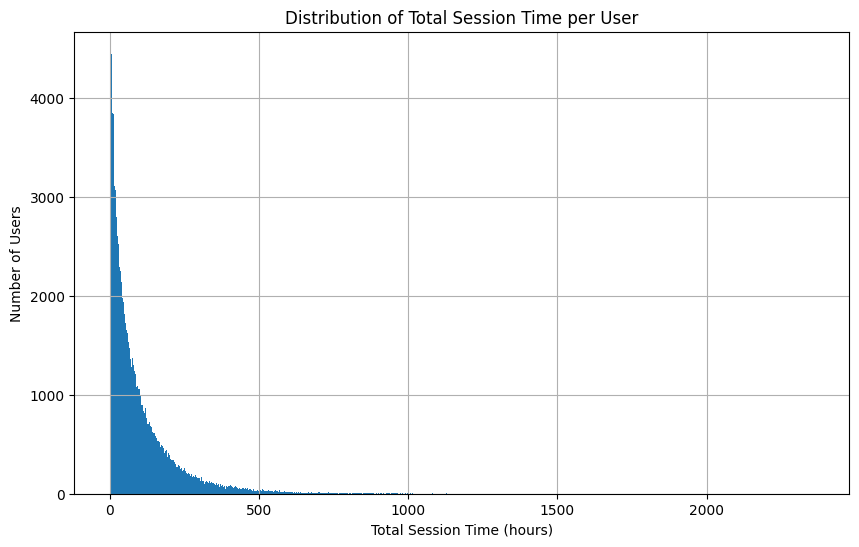

In [38]:
# 데이터 준비
data = sessions

# secs_elapsed가 없는 값을 0으로 채우기
data['secs_elapsed'] = data['secs_elapsed'].fillna(0)  # Fill missing values with 0

# 사용자별 총 세션 시간을 시간 단위로 계산
user_session_time = data.groupby('user_id')['secs_elapsed'].sum() / 3600  # Convert seconds to hours

# 총 세션 시간이 0인 사용자를 제거
user_session_time = user_session_time[user_session_time > 0]

# Define the retention period in hours (7 days)
retention_period_hours = 7 * 24

# Calculate retention: users with session time greater than or equal to the retention period
retained_users = user_session_time[user_session_time >= retention_period_hours].count()
initial_users = user_session_time.count()

# Calculate the retention rate
retention_rate = retained_users / initial_users

print(f"Retention rate over {retention_period_hours} hours: {retention_rate:.2%}")

# Plot the distribution of session times
plt.figure(figsize=(10, 6))
user_session_time.hist(bins=1000)
plt.xlabel('Total Session Time (hours)')
plt.ylabel('Number of Users')
plt.title('Distribution of Total Session Time per User')
plt.grid(True)
plt.show()

# retention 기간 별 retention 비율 시각화

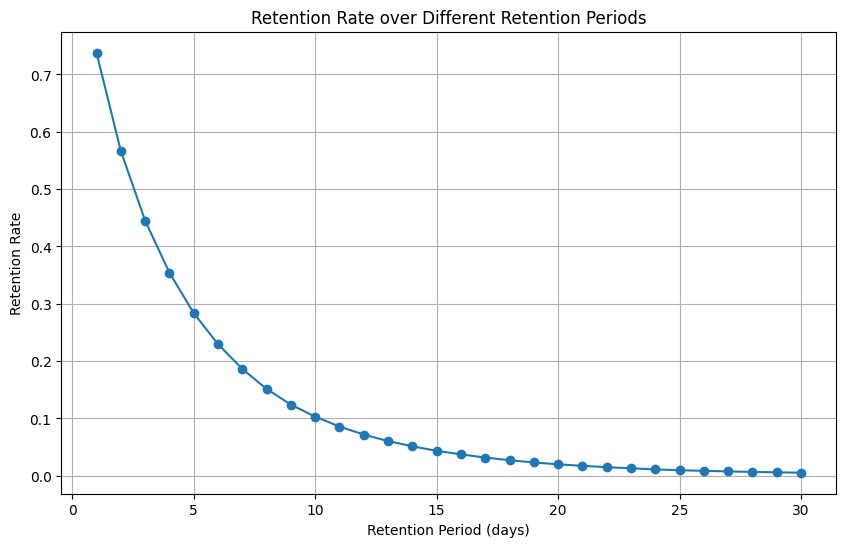

In [40]:
# secs_elapsed가 없는 값을 0으로 채우기
data['secs_elapsed'] = data['secs_elapsed'].fillna(0)  # Fill missing values with 0

# 사용자별 총 세션 시간을 시간 단위로 계산
user_session_time = data.groupby('user_id')['secs_elapsed'].sum() / 3600  # Convert seconds to hours

# 총 세션 시간이 0인 사용자를 제거
user_session_time = user_session_time[user_session_time > 0]

# 리텐션 기간 리스트 (1일, 2일, 3일, 4일 등)
retention_days = range(1, 31)  # 예를 들어 1일에서 30일까지

# 리텐션 비율 계산을 위한 빈 리스트
retention_rates = []

# 각 리텐션 기간에 대해 리텐션 비율을 계산
for days in retention_days:
    retention_period_hours = days * 24
    retained_users = user_session_time[user_session_time >= retention_period_hours].count()
    retention_rate = retained_users / user_session_time.count()
    retention_rates.append(retention_rate)

# 리텐션 비율을 플롯으로 시각화
plt.figure(figsize=(10, 6))
plt.plot(retention_days, retention_rates, marker='o', linestyle='-')
plt.xlabel('Retention Period (days)')
plt.ylabel('Retention Rate')
plt.title('Retention Rate over Different Retention Periods')
plt.grid(True)
plt.show()

# 세션 이용 시간 별 유저수 

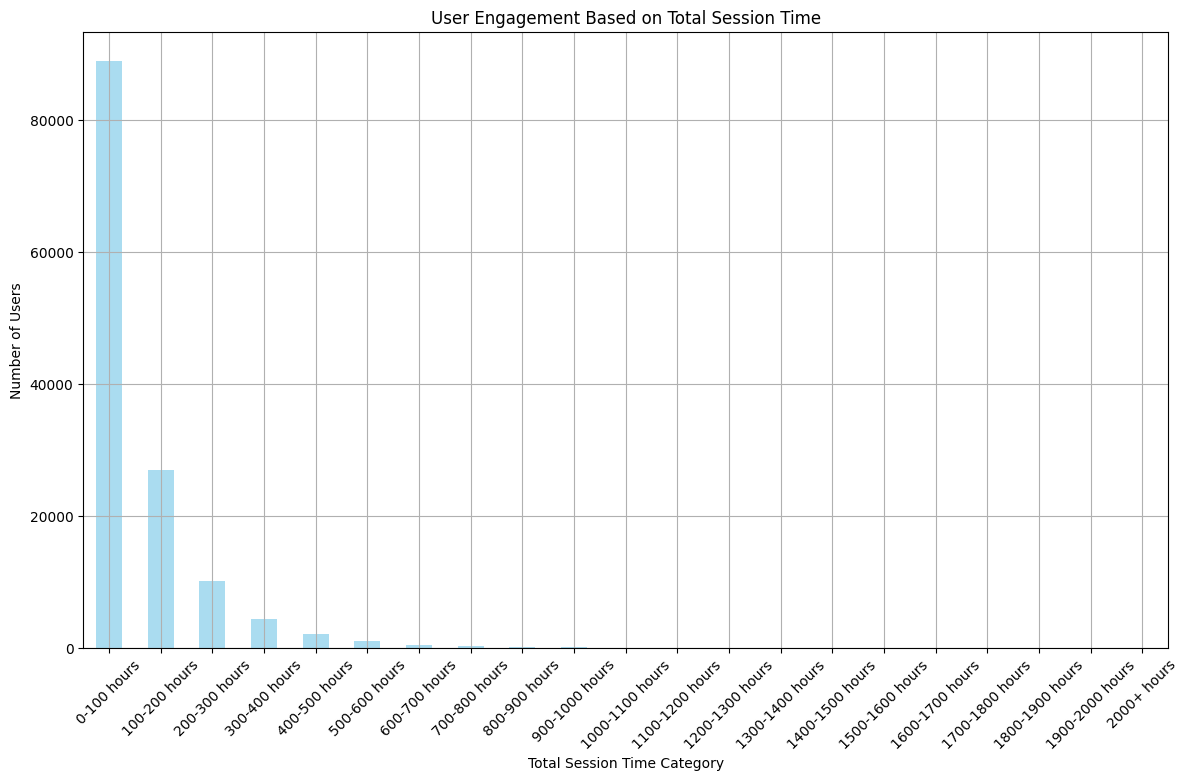

In [50]:
# secs_elapsed가 없는 값을 0으로 채우기
data['secs_elapsed'] = data['secs_elapsed'].fillna(0)  # Fill missing values with 0

# 사용자별 총 세션 시간을 시간 단위로 계산
user_session_time = data.groupby('user_id')['secs_elapsed'].sum() / 3600  # Convert seconds to hours

# 2000시간을 초과하는 사용자를 포함하도록 그룹화
bins = list(range(0, 2001, 100)) + [user_session_time.max()]
labels = [f'{i}-{i+100} hours' for i in range(0, 2000, 100)]
if user_session_time.max() > 2000:
    labels.append('2000+ hours')

# 총 세션 시간에 따라 사용자를 그룹화
user_session_time_category = pd.cut(user_session_time, bins=bins, labels=labels, right=False)

# 각 그룹의 사용자 수 계산
category_counts = user_session_time_category.value_counts().sort_index()

# 사용자 참여 카테고리 시각화
plt.figure(figsize=(14, 8))
category_counts.plot(kind='bar', color='skyblue', alpha=0.7)
plt.xlabel('Total Session Time Category')
plt.ylabel('Number of Users')
plt.title('User Engagement Based on Total Session Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 세션 소비 시간 그룹 별 첫 예약 비율

/tmp/ipykernel_95440/872468430.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  booking_rate_per_category = first_booking_per_user.groupby(filtered_session_time_category).mean()


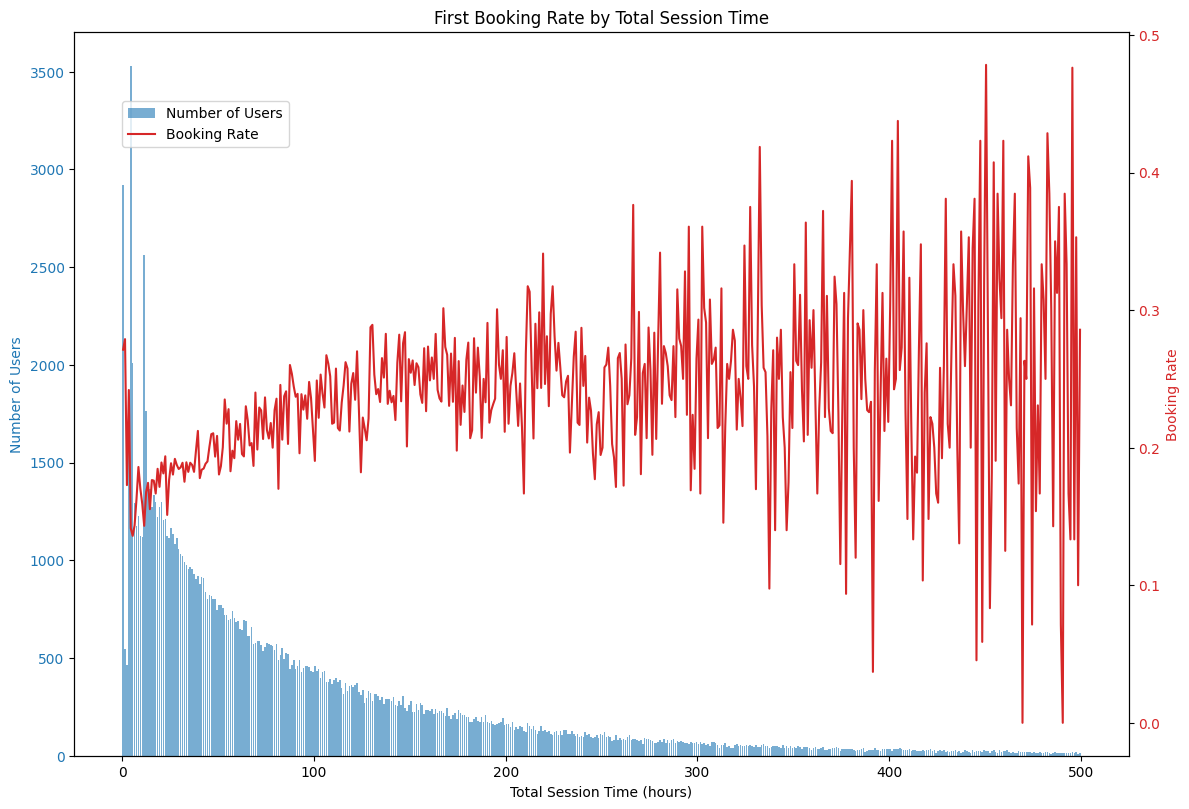

In [38]:
data = st_df

# Calculate total session time per user in hours
data['secs_elapsed'] = data['secs_elapsed'].fillna(0)  # Fill missing values with 0
user_session_time = data.groupby('user_id')['secs_elapsed'].sum() / 3600  # Convert seconds to hours

# Filter out users with total session time greater than 500 hours
filtered_session_time = user_session_time[user_session_time <= 500]

# Categorize users based on total session time
bins = range(0, 501, 1)
filtered_session_time_category = pd.cut(filtered_session_time, bins=bins, right=False)

# Calculate the count of users in each category
category_counts = filtered_session_time_category.value_counts().sort_index()

# Calculate the proportion of users who made their first booking in each category
data['has_first_booking'] = ~data['date_first_booking'].isna()
first_booking_per_user = data.groupby('user_id')['has_first_booking'].max()
first_booking_per_user = first_booking_per_user[filtered_session_time.index]  # Filter to match session times

booking_rate_per_category = first_booking_per_user.groupby(filtered_session_time_category).mean()

# Plot the distribution of session times and the booking rate
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar plot for the number of users in each category
color = 'tab:blue'
ax1.set_xlabel('Total Session Time (hours)')
ax1.set_ylabel('Number of Users', color=color)
ax1.bar(category_counts.index.categories.mid, category_counts.values, color=color, alpha=0.6, label='Number of Users')
ax1.tick_params(axis='y', labelcolor=color)

# Line plot for the booking rate
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Booking Rate', color=color)
ax2.plot(booking_rate_per_category.index.categories.mid, booking_rate_per_category.values, color=color, label='Booking Rate')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('First Booking Rate by Total Session Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

plt.show()

# 위 플롯 박스플롯으로

# 이상치 포함 박스플롯

/tmp/ipykernel_714/1523643532.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  booking_rate_per_category = first_booking_per_user.groupby(filtered_session_time_category).mean()


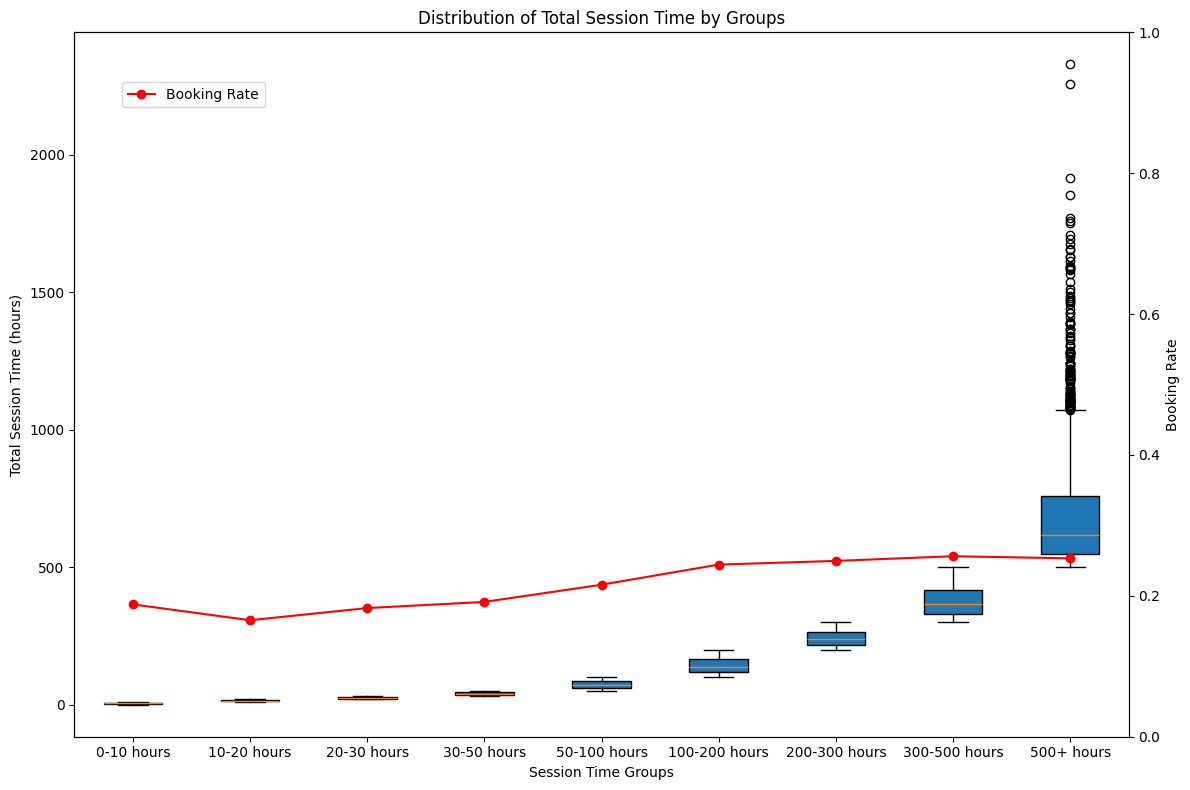

In [19]:
# 데이터 준비
data = st_df

# secs_elapsed가 없는 값을 0으로 채우기
data['secs_elapsed'] = data['secs_elapsed'].fillna(0)

# 사용자별 총 세션 시간을 시간 단위로 계산
user_session_time = data.groupby('user_id')['secs_elapsed'].sum() / 3600  # 초를 시간으로 변환

# 구간 및 라벨 정의
max_time = user_session_time.max()
bins = [0, 10, 20, 30, 50, 100, 200, 300, 500, max_time]
labels = ['0-10 hours', '10-20 hours', '20-30 hours', '30-50 hours', '50-100 hours', '100-200 hours', '200-300 hours', '300-500 hours', '500+ hours']

# 세션 시간에 따라 그룹화
filtered_session_time_category = pd.cut(user_session_time, bins=bins, labels=labels, right=False)

# 각 그룹의 사용자 수 계산
category_counts = filtered_session_time_category.value_counts().sort_index()

# 각 그룹의 첫 예약 비율 계산
data['has_first_booking'] = ~data['date_first_booking'].isna()
first_booking_per_user = data.groupby('user_id')['has_first_booking'].max()
first_booking_per_user = first_booking_per_user[user_session_time.index]  # 세션 시간과 일치하도록 필터링

# 박스플롯을 위한 데이터 준비
boxplot_data = [user_session_time[filtered_session_time_category == label] for label in labels]

# 시각화
fig, ax1 = plt.subplots(figsize=(12, 8))

# 박스플롯으로 세션 시간 분포 시각화
ax1.boxplot(boxplot_data, vert=True, patch_artist=True)
ax1.set_xticklabels(labels)
ax1.set_ylabel('Total Session Time (hours)')
ax1.set_xlabel('Session Time Groups')
ax1.set_title('Distribution of Total Session Time by Groups')

# 각 그룹의 첫 예약 비율 계산 및 시각화
booking_rate_per_category = first_booking_per_user.groupby(filtered_session_time_category).mean()

# 첫 예약 비율 선형 그래프
ax2 = ax1.twinx()
ax2.plot(range(1, len(labels) + 1), booking_rate_per_category.values, color='red', marker='o', label='Booking Rate')
ax2.set_ylabel('Booking Rate')
ax2.set_ylim(0, 1)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

plt.show()

# 이상치 제거 버전

/tmp/ipykernel_714/1744505376.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  booking_rate_per_category = first_booking_per_user.groupby(filtered_session_time_category).mean()


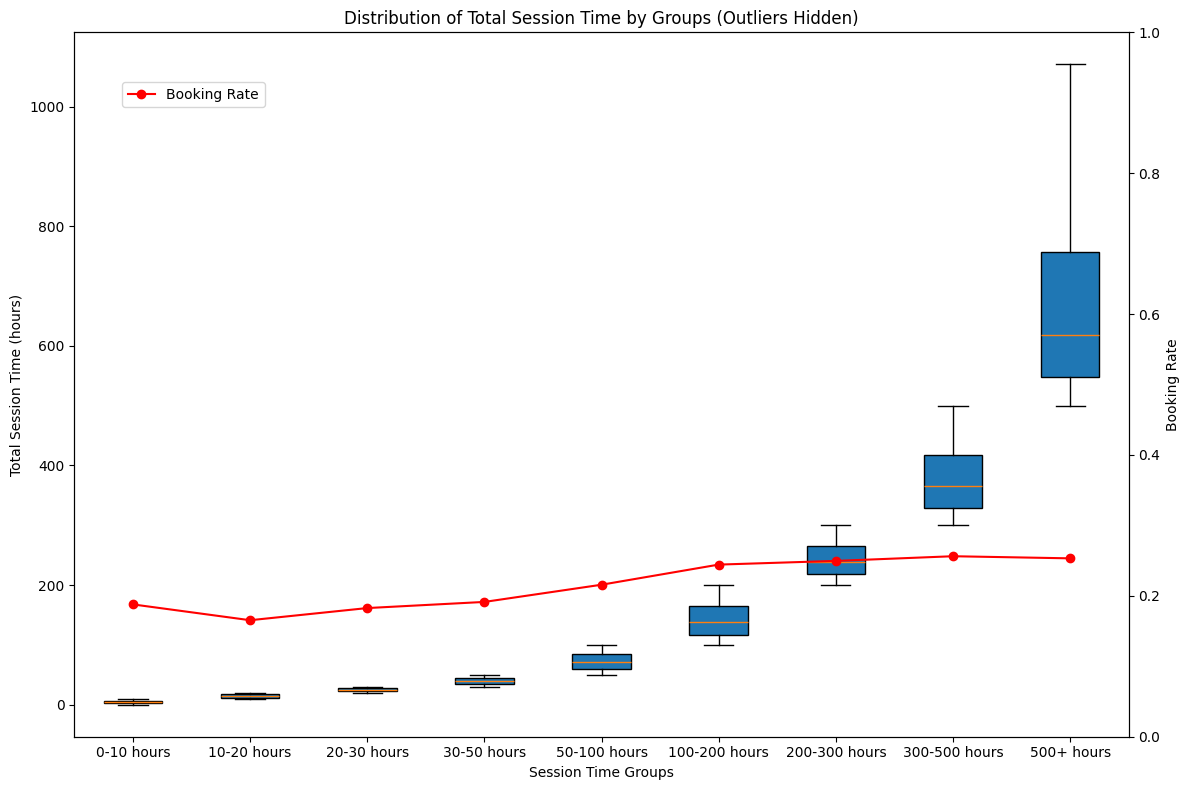

In [21]:
# 데이터 준비
data = st_df

# secs_elapsed가 없는 값을 0으로 채우기
data['secs_elapsed'] = data['secs_elapsed'].fillna(0)

# 사용자별 총 세션 시간을 시간 단위로 계산
user_session_time = data.groupby('user_id')['secs_elapsed'].sum() / 3600  # 초를 시간으로 변환

# 구간 및 라벨 정의
max_time = user_session_time.max()
bins = [0, 10, 20, 30, 50, 100, 200, 300, 500, max_time]
labels = ['0-10 hours', '10-20 hours', '20-30 hours', '30-50 hours', '50-100 hours', '100-200 hours', '200-300 hours', '300-500 hours', '500+ hours']

# 세션 시간에 따라 그룹화
filtered_session_time_category = pd.cut(user_session_time, bins=bins, labels=labels, right=False)

# 각 그룹의 사용자 수 계산
category_counts = filtered_session_time_category.value_counts().sort_index()

# 각 그룹의 첫 예약 비율 계산
data['has_first_booking'] = ~data['date_first_booking'].isna()
first_booking_per_user = data.groupby('user_id')['has_first_booking'].max()
first_booking_per_user = first_booking_per_user[user_session_time.index]  # 세션 시간과 일치하도록 필터링

# 박스플롯을 위한 데이터 준비
boxplot_data = [user_session_time[filtered_session_time_category == label] for label in labels]

# 시각화
fig, ax1 = plt.subplots(figsize=(12, 8))

# 박스플롯으로 세션 시간 분포 시각화 (이상치를 표시하지 않음)
ax1.boxplot(boxplot_data, vert=True, patch_artist=True, showfliers=False)
ax1.set_xticklabels(labels)
ax1.set_ylabel('Total Session Time (hours)')
ax1.set_xlabel('Session Time Groups')
ax1.set_title('Distribution of Total Session Time by Groups (Outliers Hidden)')

# 각 그룹의 첫 예약 비율 계산 및 시각화
booking_rate_per_category = first_booking_per_user.groupby(filtered_session_time_category).mean()

# 첫 예약 비율 선형 그래프
ax2 = ax1.twinx()
ax2.plot(range(1, len(labels) + 1), booking_rate_per_category.values, color='red', marker='o', label='Booking Rate')
ax2.set_ylabel('Booking Rate')
ax2.set_ylim(0, 1)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

plt.show()

10일 기준 재방문율

In [60]:
# Define the retention period (e.g., 7 days)
retention_period = 10

# Calculate rolling retention rate
rolling_retained_users = data[data['days_since_created'] <= retention_period]['user_id'].nunique()
rolling_retention_rate = rolling_retained_users / initial_users

print(f"{retention_period}-day rolling retention rate: {rolling_retention_rate:.2%}")

10-day rolling retention rate: 49.72%


# 예약과 관련된 action 이후 세션이 있는 유저의 기간별 히스토그램 + 전체 유저 세션 동향 라인플롯

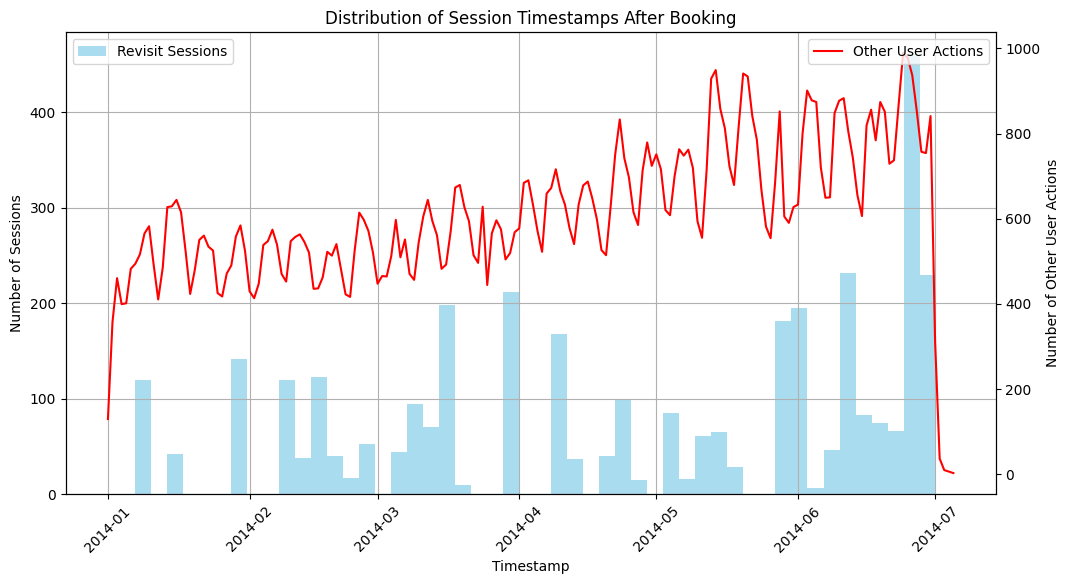

Total users: 134956
Revisit users: 161
Revisit rate: 0.12%


In [10]:
# 'book' 또는 'guest_booked_elsewhere' action을 가진 user_id 필터링
booking_actions = ['book', 'guest_booked_elsewhere']
filtered_sessions = sessions[sessions['action'].isin(booking_actions)]

# 필터링된 user_id 추출
booking_user_ids = filtered_sessions['user_id'].unique()

# 전체 세션 데이터에서 user_id의 secs_elapsed 합계가 0인 경우 제거
user_session_sums = sessions.groupby('user_id')['secs_elapsed'].sum()
valid_user_ids = user_session_sums[user_session_sums > 0].index
sessions = sessions[sessions['user_id'].isin(valid_user_ids)]

# 전체 세션 데이터에서 해당 user_id의 다음 행을 확인
# user_id가 동일한 경우를 찾기 위해 정렬
sessions = sessions.sort_values(by=['user_id', 'secs_elapsed'])

# 동일한 user_id가 다음 행에 존재하는지 확인
sessions['next_user_id'] = sessions['user_id'].shift(-1)
revisit_user_ids = sessions[(sessions['user_id'].isin(booking_user_ids)) & (sessions['user_id'] == sessions['next_user_id'])]['user_id'].unique()

# 타임스탬프 변환
sessions['session_timestamp'] = pd.to_datetime(sessions['session_timestamp'], errors='coerce')

# 예약 후 활동한 사용자의 타임스탬프 추출
revisit_sessions = sessions[sessions['user_id'].isin(revisit_user_ids)]

# 예약 후 활동 시간 분포 시각화 (히스토그램)
plt.figure(figsize=(12, 6))
plt.hist(revisit_sessions['session_timestamp'], bins=50, color='skyblue', alpha=0.7, label='Revisit Sessions')
plt.xlabel('Timestamp')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Timestamps After Booking')
plt.xticks(rotation=45)
plt.grid(True)

# 타임스탬프별 다른 유저들의 행동 수 계산
other_user_actions = sessions.groupby(sessions['session_timestamp'].dt.date)['user_id'].nunique()

# 예약 후 활동 시간 통계
revisit_sessions_by_date = revisit_sessions.groupby(revisit_sessions['session_timestamp'].dt.date).size()

# 우측 y축으로 선차트 추가
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(other_user_actions.index, other_user_actions.values, color='red', label='Other User Actions')
ax2.set_ylabel('Number of Other User Actions')
ax2.legend(loc='upper right')

ax1.legend(loc='upper left')
plt.show()

# 전체 사용자 수와 예약 후 재방문 사용자 수를 기반으로 재방문율 계산
total_users = sessions['user_id'].nunique()
revisit_users = len(revisit_user_ids)
revisit_rate = revisit_users / total_users

print(f"Total users: {total_users}")
print(f"Revisit users: {revisit_users}")
print(f"Revisit rate: {revisit_rate:.2%}")

# 재방문 비율 0.12%

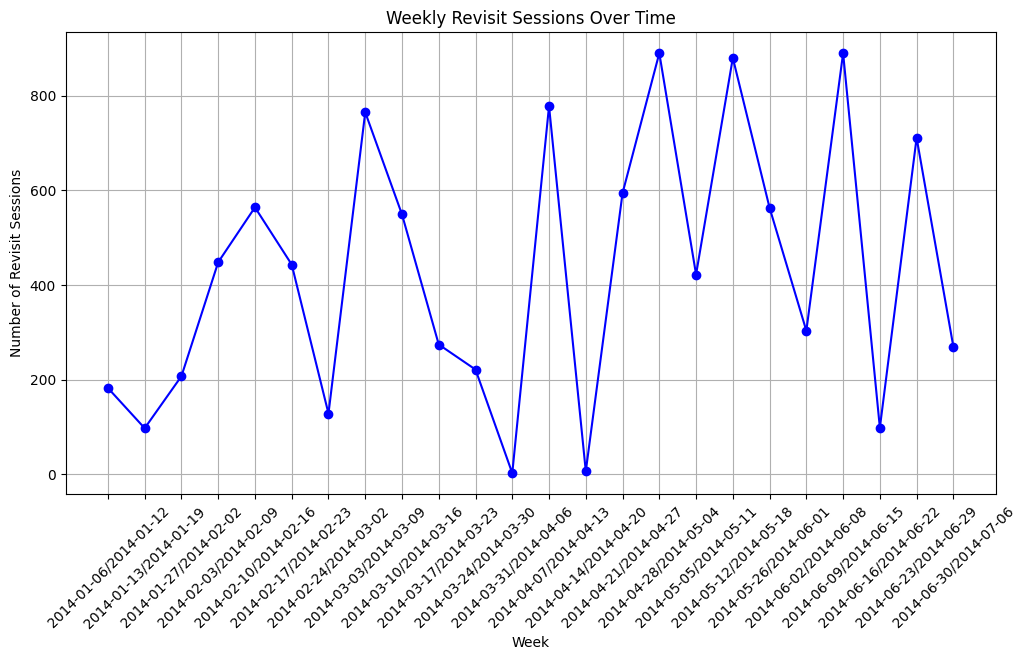

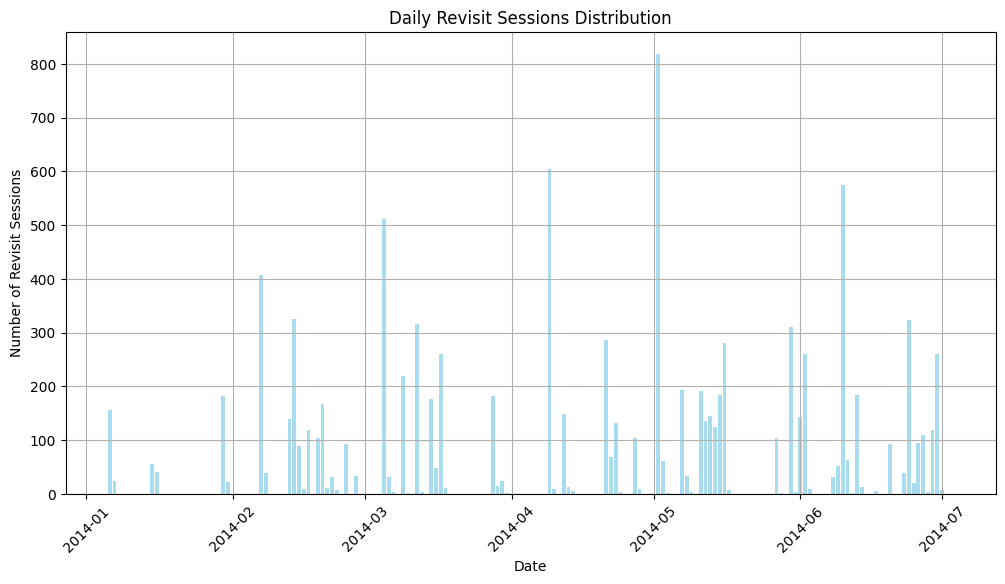

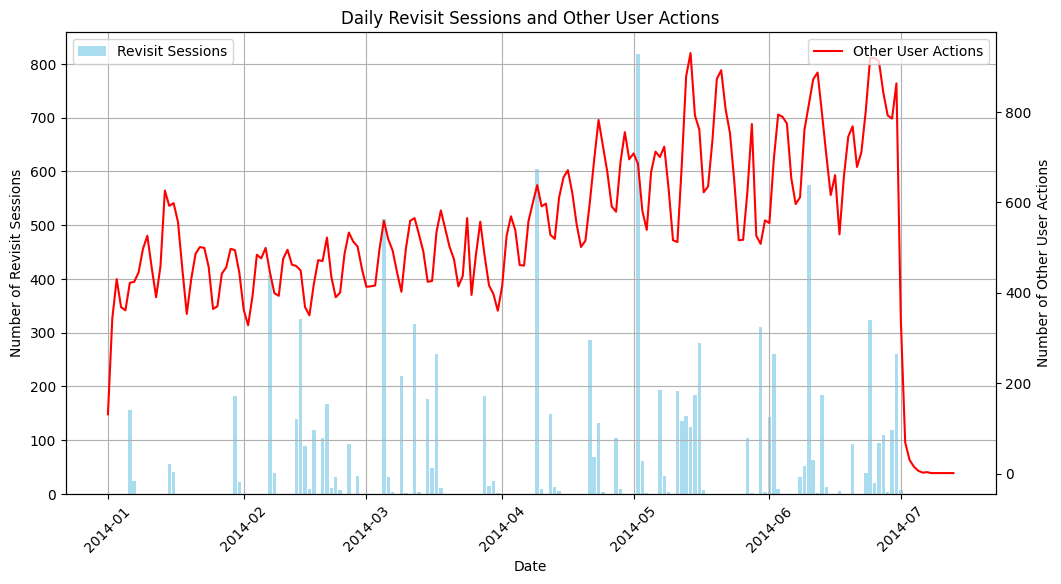

In [30]:
# 'book' 또는 'guest_booked_elsewhere' action을 가진 user_id 필터링
booking_actions = ['book', 'guest_booked_elsewhere']
filtered_sessions = sessions[sessions['action'].isin(booking_actions)]

# 필터링된 user_id 추출
booking_user_ids = filtered_sessions['user_id'].unique()

# 전체 세션 데이터에서 user_id의 secs_elapsed 합계가 0인 경우 제거
user_session_sums = sessions.groupby('user_id')['secs_elapsed'].sum()
valid_user_ids = user_session_sums[user_session_sums > 0].index
sessions = sessions[sessions['user_id'].isin(valid_user_ids)]

# 전체 세션 데이터에서 해당 user_id의 다음 행을 확인
# user_id가 동일한 경우를 찾기 위해 정렬
sessions = sessions.sort_values(by=['user_id', 'secs_elapsed'])

# 동일한 user_id가 다음 행에 존재하는지 확인
sessions['next_user_id'] = sessions['user_id'].shift(-1)
revisit_user_ids = sessions[(sessions['user_id'].isin(booking_user_ids)) & (sessions['user_id'] == sessions['next_user_id'])]['user_id'].unique()

# 타임스탬프 변환
sessions['session_timestamp'] = pd.to_datetime(sessions['session_timestamp'], errors='coerce')

# 예약 후 활동한 사용자의 타임스탬프 추출
revisit_sessions = sessions[sessions['user_id'].isin(revisit_user_ids)]

# 유효한 타임스탬프만 남기기
revisit_sessions = revisit_sessions.dropna(subset=['session_timestamp'])

# 1. 라인 차트: 주별 재방문 세션 수 시각화
revisit_sessions['week'] = revisit_sessions['session_timestamp'].dt.to_period('W').astype(str)
weekly_revisit_counts = revisit_sessions.groupby('week').size()

plt.figure(figsize=(12, 6))
plt.plot(weekly_revisit_counts.index, weekly_revisit_counts.values, marker='o', linestyle='-', color='b')
plt.xlabel('Week')
plt.ylabel('Number of Revisit Sessions')
plt.title('Weekly Revisit Sessions Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 2. 막대 차트: 세션 타임스탬프 분포 시각화
revisit_sessions['date'] = revisit_sessions['session_timestamp'].dt.date
daily_revisit_counts = revisit_sessions.groupby('date').size()

plt.figure(figsize=(12, 6))
plt.bar(daily_revisit_counts.index, daily_revisit_counts.values, color='skyblue', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Number of Revisit Sessions')
plt.title('Daily Revisit Sessions Distribution')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 타임스탬프별 다른 유저들의 행동 수 계산
other_user_actions = sessions.groupby(sessions['session_timestamp'].dt.date)['user_id'].nunique()

# 우측 y축으로 선차트 추가
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(daily_revisit_counts.index, daily_revisit_counts.values, color='skyblue', alpha=0.7, label='Revisit Sessions')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Revisit Sessions')
ax1.set_title('Daily Revisit Sessions and Other User Actions')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(other_user_actions.index, other_user_actions.values, color='red', label='Other User Actions')
ax2.set_ylabel('Number of Other User Actions')
ax2.legend(loc='upper right')

ax1.legend(loc='upper left')
plt.show()

# 일별 재방문 세션 수 (공휴일 빨간색)

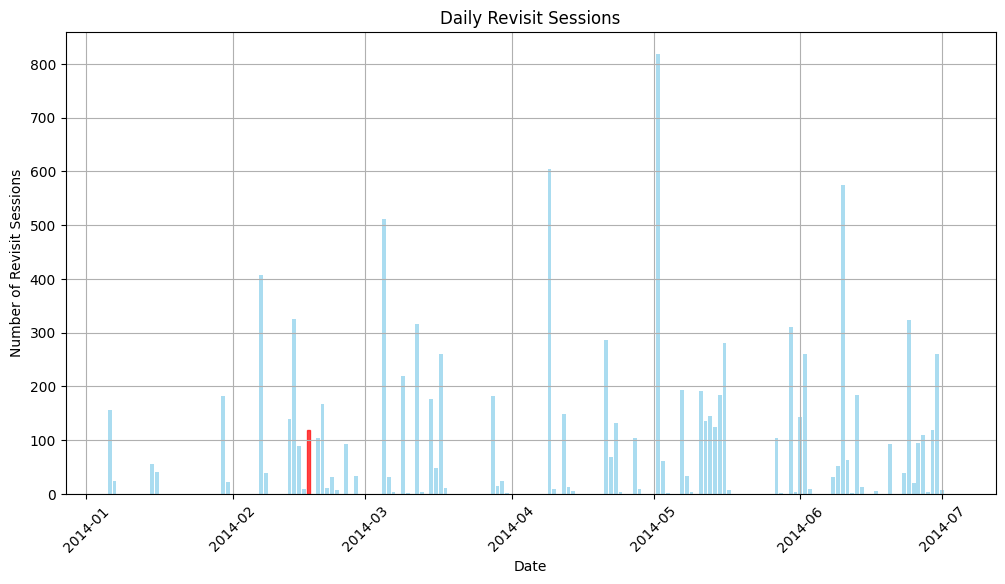

In [37]:
# 'book' 또는 'guest_booked_elsewhere' action을 가진 user_id 필터링
booking_actions = ['book', 'guest_booked_elsewhere']
filtered_sessions = sessions[sessions['action'].isin(booking_actions)]

# 필터링된 user_id 추출
booking_user_ids = filtered_sessions['user_id'].unique()

# 전체 세션 데이터에서 user_id의 secs_elapsed 합계가 0인 경우 제거
user_session_sums = sessions.groupby('user_id')['secs_elapsed'].sum()
valid_user_ids = user_session_sums[user_session_sums > 0].index
sessions = sessions[sessions['user_id'].isin(valid_user_ids)]

# 전체 세션 데이터에서 해당 user_id의 다음 행을 확인
# user_id가 동일한 경우를 찾기 위해 정렬
sessions = sessions.sort_values(by=['user_id', 'secs_elapsed'])

# 동일한 user_id가 다음 행에 존재하는지 확인
sessions['next_user_id'] = sessions['user_id'].shift(-1)
revisit_user_ids = sessions[(sessions['user_id'].isin(booking_user_ids)) & (sessions['user_id'] == sessions['next_user_id'])]['user_id'].unique()

# 타임스탬프 변환
sessions['session_timestamp'] = pd.to_datetime(sessions['session_timestamp'], errors='coerce')

# 예약 후 활동한 사용자의 타임스탬프 추출
revisit_sessions = sessions[sessions['user_id'].isin(revisit_user_ids)]

# 유효한 타임스탬프만 남기기
revisit_sessions = revisit_sessions.dropna(subset=['session_timestamp'])

# 일별 재방문 세션 수 계산
revisit_sessions['date'] = revisit_sessions['session_timestamp'].dt.date
daily_revisit_counts = revisit_sessions.groupby('date').size()

# 2014년 1월 1일부터 2014년 6월 30일까지의 미국 공휴일 목록
holidays = [
    '2014-01-01', '2014-01-20', '2014-02-17', '2014-05-26'
]
holidays = [datetime.strptime(day, '%Y-%m-%d').date() for day in holidays]

# 공휴일 표시를 위한 색상 설정
bar_colors = ['red' if day in holidays else 'skyblue' for day in daily_revisit_counts.index]

# 일별 재방문 세션 수 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))
bars = ax1.bar(daily_revisit_counts.index, daily_revisit_counts.values, color=bar_colors, alpha=0.7, label='Revisit Sessions')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Revisit Sessions')
ax1.set_title('Daily Revisit Sessions')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

# 공휴일 텍스트 색상 설정
for bar, day in zip(bars, daily_revisit_counts.index):
    if day in holidays:
        bar.set_color('red')

plt.show()

# 세션 이용시간 그룹 별 실제 예약 비율 (전체 구간)

/tmp/ipykernel_714/2210568291.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  booking_rate_per_category = first_booking_per_user.groupby(filtered_session_time_category).mean()


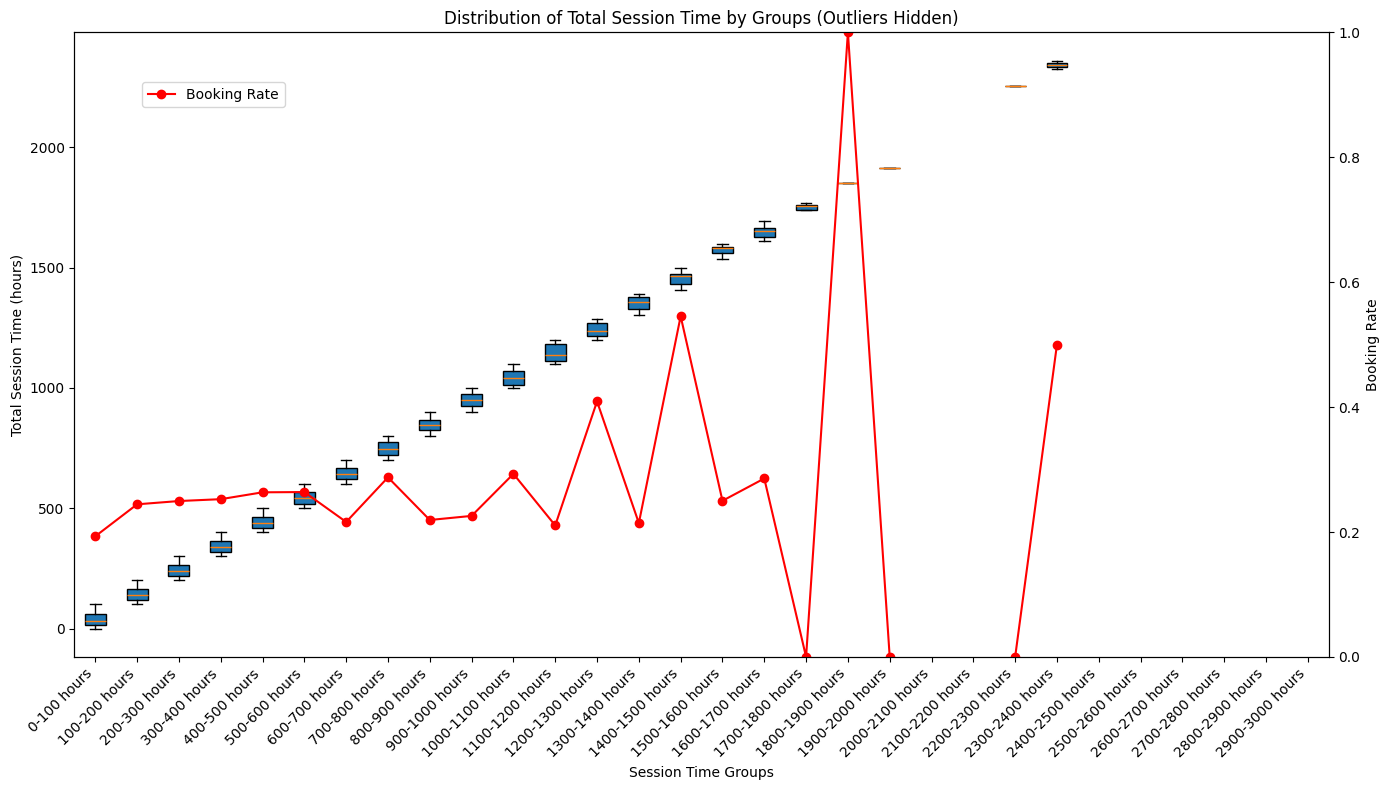

In [46]:
# 'book' 또는 'guest_booked_elsewhere' action을 가진 user_id 필터링
booking_actions = ['book', 'guest_booked_elsewhere']
filtered_sessions = sessions[sessions['action'].isin(booking_actions)]

# 필터링된 user_id 추출
booking_user_ids = filtered_sessions['user_id'].unique()

# 전체 세션 데이터에서 user_id의 secs_elapsed 합계가 0인 경우 제거
user_session_sums = sessions.groupby('user_id')['secs_elapsed'].sum()
valid_user_ids = user_session_sums[user_session_sums > 0].index
sessions = sessions[sessions['user_id'].isin(valid_user_ids)]

# 사용자별 총 세션 시간을 시간 단위로 계산
user_session_time = sessions.groupby('user_id')['secs_elapsed'].sum() / 3600  # 초를 시간으로 변환

# 최대값 확인
max_time = user_session_time.max()

# 3000시간을 초과하는 사용자를 포함하도록 그룹화
if max_time <= 3000:
    bins = list(range(0, 3001, 100))  # 최대값이 3000 이하인 경우
else:
    bins = list(range(0, 3001, 100)) + [max_time]  # 최대값이 3000 초과인 경우

labels = [f'{i}-{i+100} hours' for i in range(0, 3000, 100)]
if max_time > 3000:
    labels.append('3000+ hours')

# 총 세션 시간에 따라 사용자를 그룹화
filtered_session_time_category = pd.cut(user_session_time, bins=bins, labels=labels, right=False)

# 각 그룹의 사용자 수 계산
category_counts = filtered_session_time_category.value_counts().sort_index()

# 각 그룹의 첫 예약 비율 계산
sessions['has_first_booking'] = ~sessions['date_first_booking'].isna()
first_booking_per_user = sessions.groupby('user_id')['has_first_booking'].max()
first_booking_per_user = first_booking_per_user[user_session_time.index]  # 세션 시간과 일치하도록 필터링

# 박스플롯을 위한 데이터 준비
boxplot_data = [user_session_time[filtered_session_time_category == label] for label in labels]

# 시각화
fig, ax1 = plt.subplots(figsize=(14, 8))

# 박스플롯으로 세션 시간 분포 시각화
ax1.boxplot(boxplot_data, vert=True, patch_artist=True, showfliers=False)
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_ylabel('Total Session Time (hours)')
ax1.set_xlabel('Session Time Groups')
ax1.set_title('Distribution of Total Session Time by Groups (Outliers Hidden)')

# 각 그룹의 첫 예약 비율 계산 및 시각화
booking_rate_per_category = first_booking_per_user.groupby(filtered_session_time_category).mean()

# 첫 예약 비율 선형 그래프
ax2 = ax1.twinx()
ax2.plot(range(1, len(labels) + 1), booking_rate_per_category.values, color='red', marker='o', label='Booking Rate')
ax2.set_ylabel('Booking Rate')
ax2.set_ylim(0, 1)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.show()

# 일별 신규 사용자와 평균 세션 이용 시간

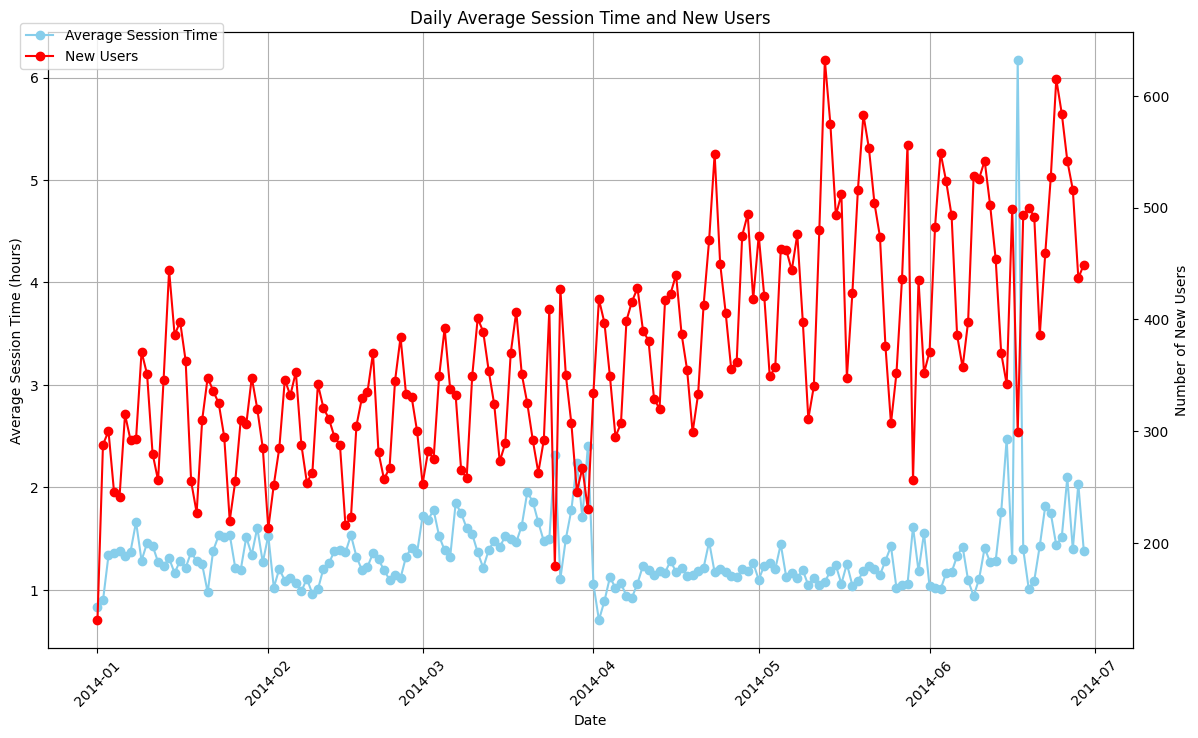

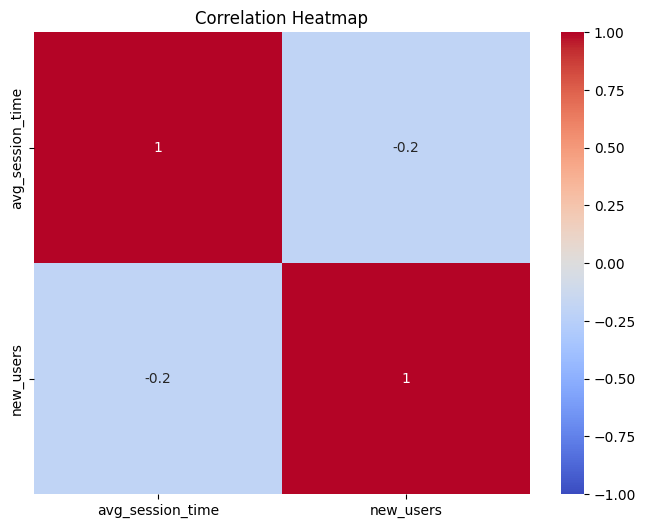

In [58]:
# secs_elapsed가 없는 값을 0으로 채우기
data['secs_elapsed'] = data['secs_elapsed'].fillna(0)  # Fill missing values with 0

# 'timestamp_first_active' 결측치 제거
data = data.dropna(subset=['timestamp_first_active'])

# 사용자별 총 세션 시간을 시간 단위로 계산 (세션 시간이 0인 유저는 제외)
user_session_time = data.groupby('user_id')['secs_elapsed'].sum() / 3600  # Convert seconds to hours
user_session_time = user_session_time[user_session_time > 0]

# 타임스탬프 변환
data['session_timestamp'] = pd.to_datetime(data['session_timestamp'], errors='coerce')
data['timestamp_first_active'] = pd.to_datetime(data['timestamp_first_active'], errors='coerce')

# 2014년 1월 1일부터 2014년 6월 30일까지의 데이터 필터링
start_date = '2014-01-01'
end_date = '2014-06-30'
data = data[(data['session_timestamp'] >= start_date) & (data['session_timestamp'] <= end_date)]

# 세션 시간이 0인 유저 제거
valid_user_ids = user_session_time.index
data = data[data['user_id'].isin(valid_user_ids)]

# 일별 평균 세션 시간 계산
data['date'] = data['session_timestamp'].dt.date
daily_avg_session_time = data.groupby('date')['secs_elapsed'].mean() / 3600  # Convert seconds to hours

# 일별 신규 유저 수 계산
data['date_first_active'] = data['timestamp_first_active'].dt.date
daily_new_users = data.drop_duplicates(subset=['user_id']).groupby('date_first_active').size()

# 시각화
fig, ax1 = plt.subplots(figsize=(14, 8))

# 일별 평균 세션 시간 시각화
ax1.plot(daily_avg_session_time.index, daily_avg_session_time.values, marker='o', linestyle='-', color='skyblue', label='Average Session Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Session Time (hours)')
ax1.set_title('Daily Average Session Time and New Users')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

# 일별 신규 유저 수 시각화
ax2 = ax1.twinx()
ax2.plot(daily_new_users.index, daily_new_users.values, marker='o', linestyle='-', color='red', label='New Users')
ax2.set_ylabel('Number of New Users')

# 범례 추가
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.show()

# 상관계수 계산 및 히트맵 시각화
merged_data = pd.DataFrame({
    'avg_session_time': daily_avg_session_time,
    'new_users': daily_new_users
}).dropna()

correlation = merged_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()